In [93]:
import pynwb
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt


### Outline
1. Behavioral objects for nodes
  * Define classes
  * Build graph with nodes and edges
  * Plot topology and geometry
2. No behavioral objects (all metadata in graph--avoids degeneracy/complexity)
  * Rebuild graph using arbitary integer labels for the nodes, with all metadata in the graph.
  * Add choice point node (eliminates cycle if required to pass through)
  * Add sleep box area with entrance hall and sleep box door
  * Make entrance hall a multi-segment path and move the door

### Define behavioral classes to represent track

In [149]:
class BehavioralPoint():
    def __init__(self, center_point, name):
        self.x = center_point[0]
        self.y = center_point[1]
        self.name = name
    
class BehavioralSegment():
    def __init__(self, segment, name):
        self.segment = segment
        self.name = name

class BehavioralArea():
    def __init__(self, polygon, name):
        self.polygon = polygon
        self.name = name

### Make behavioral objects for W-track

In [150]:
# W-track path segments
wtrack_L = BehavioralSegment([(1.6, 2.2), (1.6, 0.65)], "L")
wtrack_LC = BehavioralSegment([(1.6, 0.65), (1.9, 0.65)], "LC")
wtrack_C = BehavioralSegment([(1.9, 0.65), (1.9, 2.2)], "C")
wtrack_RC = BehavioralSegment([(1.9, 0.65), (2.2, 0.65)], "RC")
wtrack_R = BehavioralSegment([(2.2, 0.65), (2.2, 2.2)], "R")
all_segments = [wtrack_L, wtrack_LC, wtrack_C, wtrack_RC, wtrack_R]

# W-track points (wells)
wtrack_wL = BehavioralPoint((1.6, 2.2), "LW")
wtrack_wC = BehavioralPoint((1.9, 2.2), "CW")
wtrack_wR = BehavioralPoint((2.2, 2.2), "RW")
all_points = [wtrack_wL, wtrack_wC, wtrack_wR]

## Build graph for W-track
Here we are duplicating some information in the graph nodes that is also in the behavioral objects (e.g. 'name'). This makes graph operations simpler (i.e. drawing a graph with nodes labeled by 'name') and allows encapuslation of info about each node, but we get this at the expense of the possibility of degeneracy and complexity. Another option is to not use the behavioral objects, and instead just put all relevant information as graph attributes. We will explore this further [below](#no_objects).

### Add nodes

In [151]:
G = nx.Graph(name='w-track')

# Add nodes to the graph
# ----------------------
# Track segments
for seg in all_segments:
    G.add_node(seg, name=seg.name, kind='segment')
# Wells
for pt in all_points:
    G.add_node(pt, name=pt.name, kind='point')

### Add edges (corresponding to the W-track topology)

In [152]:
# Add edges connecting the appropriate nodes
# -----------------------------------------
# Segment <-> Segment
G.add_edge(wtrack_L, wtrack_LC)
G.add_edge(wtrack_LC, wtrack_C)
G.add_edge(wtrack_RC, wtrack_C)
G.add_edge(wtrack_LC, wtrack_RC)
G.add_edge(wtrack_RC, wtrack_R)
# Segment <-> Well
G.add_edge(wtrack_L, wtrack_wL)
G.add_edge(wtrack_C, wtrack_wC)
G.add_edge(wtrack_R, wtrack_wR)

### Plot track topology

Adding a separate choice point node that must be passed through would remove the cycle.


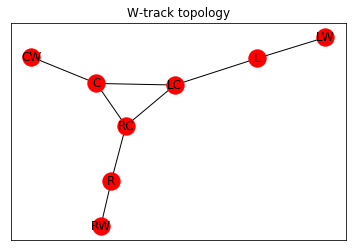

In [153]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology")
nx.draw_networkx(G, labels=dict(G.nodes.data('name')), fontsize=6)

print("Adding a separate choice point node that must be passed through would remove the cycle.")


### Plot track geometry

Text(0,0.5,'y pos (meters)')

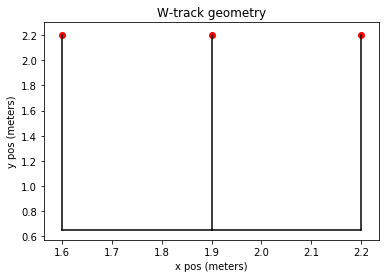

In [154]:
ax = plt.subplot(111)
plt.title('W-track geometry')
for n, attrs in list(G.nodes.data()):
    if attrs['kind']=='point':
        plt.scatter([n.x], [n.y], color='r')
    if attrs['kind']=='segment':
        start = n.segment[0]
        end = n.segment[1]
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')

<a name='no_objects'></a>
### Alternate: Do not use behavioral objects. Store all metadata in graph attrs.
As discussed above, having behavioral objects encapsulates the data at the expense of introducing some degeneracy in the metadata. Instead, we can have graph nodes be arbitary integers, with all metadata contained as graph attributes.  

In [155]:
H = nx.convert_node_labels_to_integers(G)
print("Note that we have lost information about the geometry of the objects!")
print("These data were in the behavioral objects...\n")
list(H.nodes.data())

Note that we have lost information about the geometry of the objects!
These data were in the behavioral objects...



[(0, {'name': 'L', 'kind': 'segment'}),
 (1, {'name': 'LC', 'kind': 'segment'}),
 (2, {'name': 'C', 'kind': 'segment'}),
 (3, {'name': 'RC', 'kind': 'segment'}),
 (4, {'name': 'R', 'kind': 'segment'}),
 (5, {'name': 'LW', 'kind': 'point'}),
 (6, {'name': 'CW', 'kind': 'point'}),
 (7, {'name': 'RW', 'kind': 'point'})]

### Recover the geometry metadata and store in the graph attrs

In [156]:
name_list = [e[1] for e in list(H.nodes.data('name'))]  # list of names of each node, in index order

# For path objects, store the [(x1, y1), (x2, y2)] of the segment start and end points
for seg in all_segments:
    idx = name_list.index(seg.name)
    H.nodes[idx]['segment'] = seg.segment
    
# For point objects, store the (x, y) coordinate of the point
for pt in all_points:
    idx = name_list.index(pt.name)
    H.nodes[idx]['coord'] = (pt.x, pt.y)

print("Now we have the geometry metadata in the graph attributes: \n")
list(H.nodes.data())

Now we have the geometry metadata in the graph attributes: 



[(0, {'name': 'L', 'kind': 'segment', 'segment': [(1.6, 2.2), (1.6, 0.65)]}),
 (1, {'name': 'LC', 'kind': 'segment', 'segment': [(1.6, 0.65), (1.9, 0.65)]}),
 (2, {'name': 'C', 'kind': 'segment', 'segment': [(1.9, 0.65), (1.9, 2.2)]}),
 (3, {'name': 'RC', 'kind': 'segment', 'segment': [(1.9, 0.65), (2.2, 0.65)]}),
 (4, {'name': 'R', 'kind': 'segment', 'segment': [(2.2, 0.65), (2.2, 2.2)]}),
 (5, {'name': 'LW', 'kind': 'point', 'coord': (1.6, 2.2)}),
 (6, {'name': 'CW', 'kind': 'point', 'coord': (1.9, 2.2)}),
 (7, {'name': 'RW', 'kind': 'point', 'coord': (2.2, 2.2)})]

### Plot track topology (no behavioral objects)

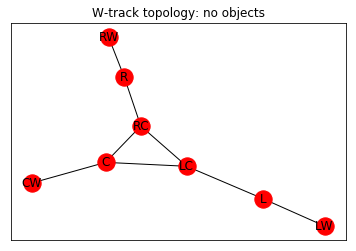

In [157]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology: no objects")
nx.draw_networkx(H, labels=dict(H.nodes.data('name')), fontsize=6)

### Add a choice point node to the graph

In [158]:
choice_pt_idx = H.number_of_nodes()
H.add_node(choice_pt_idx, name='CP', kind='point', coord=(1.9, 0.65))

### Connect the choice point to the correct other nodes

In [159]:
name_list = [e[1] for e in list(H.nodes.data('name'))]  # list of names of each node, in index order
for i, name in enumerate(name_list):
    if name == 'C' or name == 'LC' or name == 'RC':
        H.add_edge(choice_pt_idx, i)

### Plot track topology (with choice point)

Not that presently the graph allows skipping the choice point...


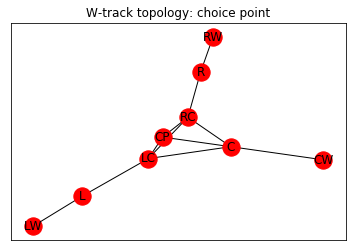

In [160]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology: choice point")
nx.draw_networkx(H, labels=dict(H.nodes.data('name')), fontsize=6)

print("Not that presently the graph allows skipping the choice point...")

### Remove edges that bipass the choice point

In [161]:
name_list = [e[1] for e in list(H.nodes.data('name'))]  # list of names of each node, in index order
c_idx = name_list.index('C')
lc_idx = name_list.index('LC')
rc_idx = name_list.index('RC')
H.remove_edge(c_idx, lc_idx)
H.remove_edge(c_idx, rc_idx)
H.remove_edge(lc_idx, rc_idx)

### Plot track topology (choice pt, no bipass)

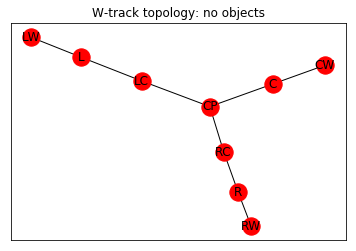

In [162]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology: no objects")
nx.draw_networkx(H, labels=dict(H.nodes.data('name')), fontsize=6)

### Plot track geometry (choice pt, no bipass)

Text(0,0.5,'y pos (meters)')

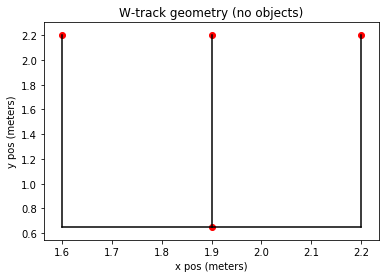

In [163]:
ax = plt.subplot(111)
plt.title('W-track geometry (no objects)')
for n, attrs in list(H.nodes.data()):
    if attrs['kind']=='point':
        coord = attrs['coord']
        plt.scatter([coord[0]], [coord[1]], color='r')
    if attrs['kind']=='segment':
        start, end = attrs['segment']
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')

### Add sleep box connected to the track by an entrance hall

In [164]:
sleep_box = [(1.8, 0.4), (2.0, 0.4), (2.0, 0.0), (1.8, 0.0)]  # polygon
entrance_hall = [(1.9, 0.4), (1.9, 0.65)] # segment
sleep_box_door = (1.9, 0.4) # point

# Add nodes to graph
next_idx = H.number_of_nodes()
H.add_node(next_idx, name='SB', kind='area', polygon=sleep_box)
H.add_node(next_idx+1, name='EH', kind='segment', segment=entrance_hall)
H.add_node(next_idx+2, name='SBD', kind='point', coord=sleep_box_door)

# Connect edges
name_list = [e[1] for e in list(H.nodes.data('name'))]  # list of names of each node, in index order
cp_idx = name_list.index('CP')
eh_idx = name_list.index('EH')
sbd_idx = name_list.index('SBD')
sb_idx = name_list.index('SB')
H.add_edge(cp_idx, eh_idx)
H.add_edge(eh_idx, sbd_idx)
H.add_edge(sbd_idx, sb_idx)


### Plot topology (with sleep box area)

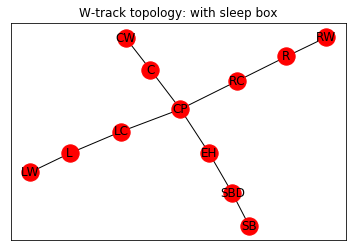

In [165]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology: with sleep box")
nx.draw_networkx(H, labels=dict(H.nodes.data('name')), fontsize=6)

### Plot geometry (with sleep box area)

Text(0,0.5,'y pos (meters)')

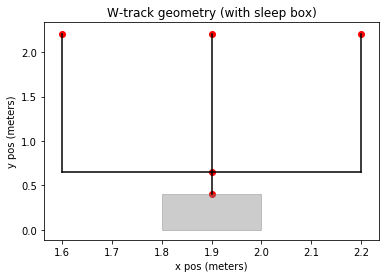

In [171]:
ax = plt.subplot(111)
plt.title('W-track geometry (with sleep box)')
for n, attrs in list(H.nodes.data()):
    if attrs['kind']=='point':
        coord = attrs['coord']
        plt.scatter([coord[0]], [coord[1]], color='r')
    if attrs['kind']=='segment':
        start, end = attrs['segment']
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
    if attrs['kind']=='area':
        poly = attrs['polygon']
        xs = [e[0] for e in poly]
        ys = [e[1] for e in poly]
        plt.fill(xs, ys, color='grey', alpha=0.4)
                
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')


### Make the entrance hall a multi-segment

In [142]:
multi_seg_eh = [(1.9, 0.65), (1.925, 0.5), (1.95, 0.45), (2.025, 0.45), (2.05, 0.3), (2.05, 0.2), (2.0, 0.2)]
eh_idx = name_list.index('EH')
H.nodes[eh_idx]['segment'] = multi_seg_eh
H.nodes[eh_idx]['kind'] = 'multi_segment'

new_sb_door = (2.0, 0.2)
sbd_idx = name_list.index('SBD')
H.nodes[sbd_idx]['coord'] = new_sb_door

### Ensure that this doesn't change the topology

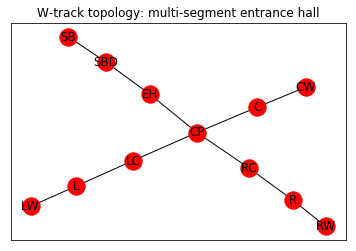

In [145]:
ax = plt.subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title("W-track topology: multi-segment entrance hall")
nx.draw_networkx(H, labels=dict(H.nodes.data('name')), fontsize=6)

### But it does change the geometry

Text(0,0.5,'y pos (meters)')

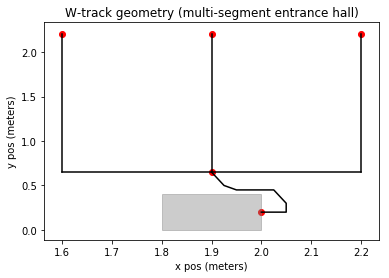

In [147]:
ax = plt.subplot(111)
plt.title('W-track geometry (multi-segment entrance hall)')
for n, attrs in list(H.nodes.data()):
    if attrs['kind']=='point':
        coord = attrs['coord']
        plt.scatter([coord[0]], [coord[1]], color='r')
    if attrs['kind']=='segment':
        start, end = attrs['segment']
        plt.plot([start[0], end[0]], [start[1], end[1]], color='k')
    if attrs['kind']=='area':
        poly = attrs['polygon']
        xs = [e[0] for e in poly]
        ys = [e[1] for e in poly]
        plt.fill(xs, ys, color='grey', alpha=0.4)
    if attrs['kind']=='multi_segment':
        multi_seg = attrs['segment']
        xs = [e[0] for e in multi_seg]
        ys = [e[1] for e in multi_seg]
        plt.plot(xs, ys, color='k')
                
plt.xlabel('x pos (meters)')
plt.ylabel('y pos (meters)')

### Exporting graph connectivity to Pandas
Convert arbitrary node numbers to their names using metadata lookups

In [197]:
idx_names = list(H.nodes.data('name'))
node_names = [e[1] for e in idx_names]

print("Adjacency Matrix")
adj = nx.to_pandas_adjacency(H)
adj.columns = node_names
adj.index = node_names
print(adj)

print('\n')

print("Edge List")
edgelist = nx.to_pandas_edgelist(H)
for index, row in edgelist.iterrows():
    source_name = idx_names[row['source']][1]
    target_name = idx_names[row['target']][1]
    edgelist.loc[index, 'source'] = source_name
    edgelist.loc[index, 'target'] = target_name
print(edgelist)

Adjacency Matrix
       L   LC    C   RC    R   LW   CW   RW   CP   SB   EH  SBD
L    0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
LC   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
C    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
RC   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
R    0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
LW   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CW   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
RW   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
CP   0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
SB   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
EH   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0
SBD  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0


Edge List
   source target
0       L     LC
1       L     LW
2      LC     CP
3       C     CW
4       C     CP
5      RC      R
6      RC     CP
7  